Compara modelos basados en redes recurrentes y convolucionales para el reconocimiento de comandos de voz usando el conjunto Speech Commands3. En particular, deberás:

* Entrenar y evaluar un modelo basado en capas convolucionales 1D.
* Entrenar y evaluar un modelo basado en capas convolucionales 2D.
* Graficar las pérdidas y métricas de entrenamiento y validación y discutir todos los resultados.
* En todos los casos, se deberán representar los comandos de voz mediante espectogramas Mel,
* Mel-Log o MFCCs.

# Preparación

In [ ]:
! pip install torchinfo
try:
    import torchaudio
except:
    ! pip install torchaudio

In [ ]:
!pip install librosa

## Bibliotecas

In [ ]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# audio
import librosa
import librosa.display
import IPython as ip
import IPython.display as ipd

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# redes audio
import torchaudio
import torchaudio.transforms as T
# redes visión
import torchvision.models as tvm

# redes neuronales
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
# inspección de arquitectura
from torchinfo import summary

# barras de progreso
from tqdm.auto import trange

#Counter
import collections

# Files
from os.path import join

# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# audio
import librosa
import librosa.display
import IPython as ip
import IPython.display as ipd

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# redes audio
import torchaudio
import torchaudio.transforms as T
# redes visión
import torchvision.models as tvm

# redes neuronales
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
# inspección de arquitectura
from torchinfo import summary

# barras de progreso
from tqdm.auto import trange

#Counter
import collections

# Files
from os.path import join
import torch as th


from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
pwd

'/home/carmen/DL'

In [ ]:
#! mkdir audio

In [ ]:
cd audio

/home/carmen/DL/audio


In [ ]:
DATA_DIR = '/home/carmen/DL/audio'

In [ ]:
# Se utiliza el conjunto de datos SPEECHCOMMANDS:
# https://pytorch.org/audio/stable/generated/torchaudio.datasets.SPEECHCOMMANDS.html#torchaudio.datasets.SPEECHCOMMANDS
ds = SPEECHCOMMANDS(DATA_DIR, download=False)

# Data Set

In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

validation_set = SubsetSC("validation")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


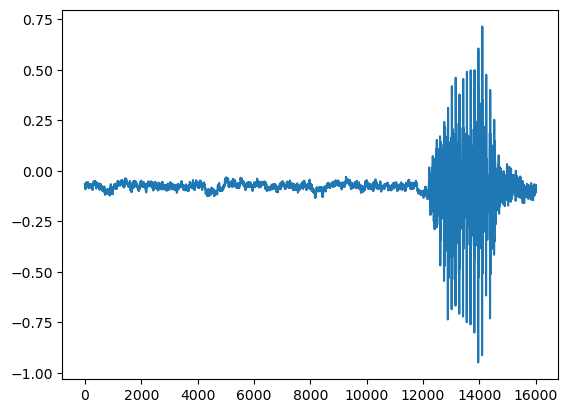

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

## Exploración de datos

Distribución de la categorias

Text(0, 0.5, 'Número de muestras')

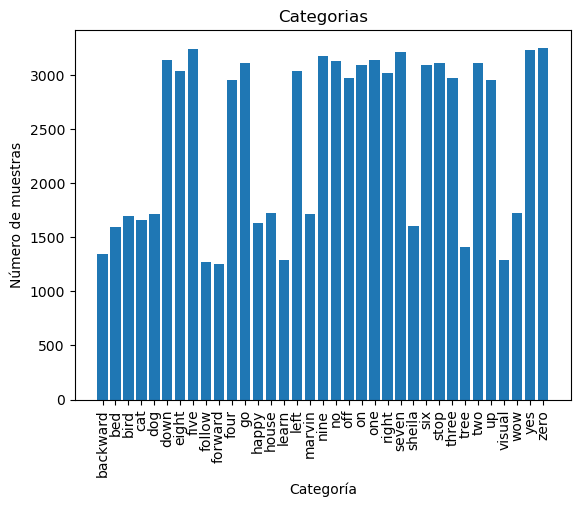

In [ ]:
cat = [d[2] for d in train_set]

idx, cuentas = np.unique(cat, return_counts=True)
plt.bar(x=idx, height=cuentas)
plt.title('Categorias')
plt.xlabel("Categoría")
plt.xticks(rotation=90)
plt.ylabel("Número de muestras")

## Formatear los datos

Este es un buen lugar para aplicar transformaciones a los datos. Para el
forma de onda, reducimos la resolución del audio para un procesamiento más rápido sin perder
demasiado del poder de clasificación.

No necesitamos aplicar otras transformaciones aquí. Es común para algunos
Sin embargo, los conjuntos de datos tienen que reducir el número de canales (por ejemplo, desde
estéreo a mono) tomando la media a lo largo de la dimensión del canal,
o simplemente manteniendo sólo uno de los canales. Dado que SpeechCommands utiliza un
canal único para audio, esto no es necesario aquí.




In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [ ]:
transformed.shape

torch.Size([1, 8000])

We are encoding each word using its index in the list of labels.


In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 32

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

test_valida_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Caracteristicas

El valor de n_fft determina la resolución del eje de frecuencia.

hop_length determina la resolución del eje de tiempo. De forma predeterminada se utiliza el valor de n_fft // 4.

In [ ]:
# tamaño de la ventana
n_fft = 1000
# tamaño del salto
hop_length = n_fft // 2

### Espectogramas

Para obtener la composición de frecuencia de una señal de audio que varía con el tiempo, puede usar torchaudio.transforms.Spectrogram().

Los humanos perciben la frecuencia de forma logarítmica.

In [ ]:
spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)(waveform)
print(spectrogram.shape, spectrogram.dtype)
spectrogram

torch.Size([1, 501, 33]) torch.float32


tensor([[[1.3074e+03, 1.5869e+03, 1.8326e+03,  ..., 1.4591e+03,
          1.9896e+03, 2.5053e+03],
         [3.3141e+02, 3.5917e+02, 5.3161e+02,  ..., 3.7860e+02,
          5.3642e+02, 5.8894e+02],
         [1.8669e-01, 5.9004e+00, 8.0151e+00,  ..., 1.7591e+00,
          9.2631e+00, 3.2580e+00],
         ...,
         [5.6647e-05, 1.1737e-05, 5.1757e-05,  ..., 7.8968e-06,
          3.1872e-05, 2.5111e-05],
         [4.9629e-05, 2.0518e-06, 2.4939e-05,  ..., 1.4893e-06,
          1.6991e-05, 1.0306e-05],
         [1.9988e-05, 2.2418e-06, 4.2477e-05,  ..., 1.6151e-05,
          1.1295e-04, 1.3285e-04]]])

#### Espectrogramas Mel:

/home/carmen/anaconda3/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


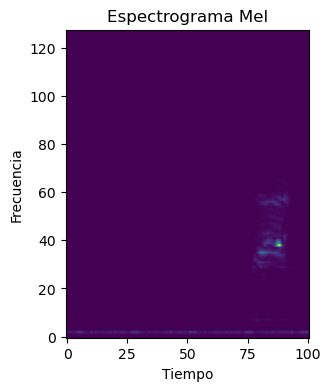

In [ ]:
import torchaudio.transforms as T
import matplotlib.pyplot as plt

# Configurar los parámetros para los espectrogramas Mel
n_mels = 128
n_fft = 400
win_length = 400
hop_length = 160

# Crear una instancia de la transformación Spectrogram
mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels
)

# Calcular el espectrograma Mel
mel_spec = mel_spectrogram(waveform)

# Visualizar el espectrograma Mel
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec[0].numpy(), cmap='viridis', origin='lower')
plt.title('Espectrograma Mel')
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')
plt.show()


#### Espectrogramas Mel-Log:

/home/carmen/anaconda3/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


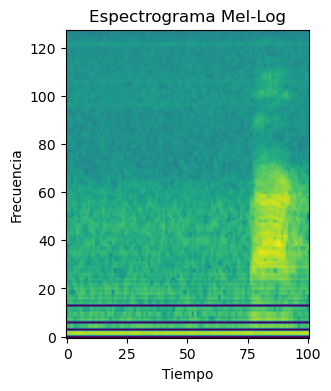

In [ ]:
# Configurar los parámetros para los espectrogramas Mel
n_mels = 128
n_fft = 400
win_length = 400
hop_length = 160

# Crear una instancia de la transformación Spectrogram
mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels
)

# Calcular el espectrograma Mel
mel_spec = mel_spectrogram(waveform)

# Aplicar la transformación de logaritmo
mel_log_spec = T.AmplitudeToDB()(mel_spec)

# Visualizar el espectrograma Mel-Log
plt.figure(figsize=(10, 4))
plt.imshow(mel_log_spec[0].numpy(), cmap='viridis', origin='lower')
plt.title('Espectrograma Mel-Log')
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
mel_spec.shape

torch.Size([1, 128, 101])

#### MFCCs (Mel-Frequency Cepstral Coefficients):

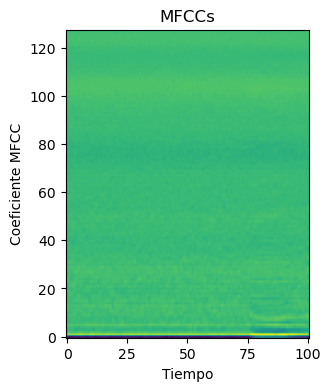

In [ ]:

# Configurar los parámetros para los MFCCs
n_mfcc = 128
n_mels = 128
n_fft = 400
win_length = 400
hop_length = 160

# Crear una instancia de la transformación MFCC
mfcc = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={'n_fft': n_fft, 'hop_length': hop_length, 'n_mels': n_mels}
)

# Calcular los MFCCs
mfccs = mfcc(waveform)


# Visualizar los MFCCs
plt.figure(figsize=(10, 4))
plt.imshow(mfccs[0].numpy(), cmap='viridis', origin='lower')
plt.title('MFCCs')
plt.xlabel('Tiempo')
plt.ylabel('Coeficiente MFCC')
plt.show()


In [ ]:
mfccs.shape

torch.Size([1, 128, 101])

# 2. Modelo basado en capas convolucionales 1D


## 2. 1 Arquitectura

Usaremos una red neuronal convolucional para procesar los datos de audio sin procesar. Generalmente se aplican transformaciones más avanzadas a la datos de audio, sin embargo, las CNN se pueden utilizar para procesar con precisión los datos sin procesar.

La arquitectura específica está modelada a partir de la arquitectura de red M5.
descrito en [este artículo](https://arxiv.org/pdf/1610.00087.pdf)_. Un
Un aspecto importante de los modelos que procesan datos de audio sin procesar es la receptividad.
campo de los filtros de su primera capa. El primer filtro de nuestro modelo es la longitud.
80, por lo que al procesar audio muestreado a 8 kHz, el campo receptivo es
alrededor de 10 ms (y a 4 kHz, alrededor de 20 ms). Este tamaño es similar al discurso.
aplicaciones de procesamiento que a menudo utilizan campos receptivos que van desde
20 ms a 40 ms.



In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

Usaremos la misma técnica de optimización utilizada en el artículo, una Adam
optimizador con caída de peso establecida en 0,0001. Al principio entrenaremos con
una tasa de aprendizaje de 0.01, pero usaremos un ``programador`` para disminuirla
a 0.001 durante el entrenamiento después de 20 épocas.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

# Funciones de entrenamiento

In [ ]:
def guarda_ckpt(ckptpath, modelo, epoca, opt):
  estado_modelo = {'epoch': epoca,
                   'model_state_dict': modelo.state_dict(),
                   'optimizer_state_dict': opt.state_dict()}
  torch.save(estado_modelo, ckptpath)


from torch.utils.tensorboard import SummaryWriter

def registra_info_tboard(writer, epoca, hist):
  for (m,v) in hist.items():
    writer.add_scalar(m, v[epoca], epoca)


def exactitud(y_hat, y):
  cmp = y_hat.argmax(dim=-1) == y
  aciertos = torch.count_nonzero(cmp)
  return aciertos / cmp.shape[0]


def paso_ent(modelo,
             fp,
             metrica,
             opt,
             X,
             y):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                    # a actualizaren en cero
  y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
  perdida = fp(y_hat.squeeze(), y) # se calcula la pérdida
  perdida.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo

  with th.no_grad():
    #perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
    perdida_paso = perdida.to('cpu').numpy()


    metricas_paso = metrica(y_hat.cpu().squeeze(), y.cpu())

  return perdida_paso, metricas_paso



import copy

def entrena(modelo,
            fp,
            metrica,
            opt,
            entdl,
            valdl,
            disp,
            ckptpath,
            transform,
            n_epocas = 10,
            tbdir = 'runs/',
            spectrogram =  False,
            log_mel = False):
  n_lotes_ent = len(entdl)
  n_lotes_val = len(valdl)

  hist = {'perdida_ent':np.zeros(n_epocas),
          'perdida_val': np.zeros(n_epocas),
          metrica.__name__ + '_ent': np.zeros(n_epocas),
          metrica.__name__ + '_val': np.zeros(n_epocas)}

  tbwriter = SummaryWriter(tbdir)
  perdida_min = th.inf
  mejor_modelo = copy.deepcopy(modelo)

  with tqdm(total=n_epocas) as pbar:
    for e in range(n_epocas):
      # bucle de entrenamiento
      modelo.train()
      for p, (Xlote, ylote) in enumerate(entdl):
        #Xlote = Xlote.float()  # Convierte la entrada a punto flotante (float)
        #Xlote = Xlote.type(torch.LongTensor)
        #Xlote = Xlote.to(torch.float32)
        #Xlote = Xlote.to(torch.float)
        Xlote = Xlote.to(disp)

        if log_mel:
          for transf in transform:
            transf = transf.to(device)
            Xlote = transf(Xlote)
        else:
          Xlote = transform(Xlote)  # apply transform and model on whole batch directly on device
        #print('Xlote.shape ' , Xlote.shape)



        if spectrogram:
            #modificamos para que las dimensiones conincidan con las del modelo
             #Se aplanan
            Xlote = torch.flatten(Xlote, start_dim=1)
            Xlote = Xlote.view(Xlote.shape[0], 1, Xlote.shape[1])

        #ylote = ylote.type(torch.LongTensor)
        ylote = ylote.to(disp)
       # print(ylote.shape)

        perdida_paso, metrica_paso = paso_ent(modelo,
                                              fp,
                                              metrica,
                                              opt,
                                              Xlote,
                                              ylote)

        hist['perdida_ent'][e] += perdida_paso
        hist[metrica.__name__ + '_ent'][e] += metrica_paso

      # bucle de validación
      modelo.eval()
      scheduler.step()

      with th.no_grad():
        for Xlote,ylote in valdl:
        # Xlote = Xlote.float()  # Convierte la entrada a punto flotante (float)
          #print(X.to)
          #Xlote = Xlote.to(torch.float32)
          #Xlote = Xlote.to(torch.float)
          Xlote = Xlote.to(disp)

          if log_mel:
            for transf in transform:
              transf = transf.to(device)
              Xlote = transf(Xlote)
          else:
            Xlote = transform(Xlote)  # apply transform and model on whole batch directly on device
          #print('Xlote.shape ' , Xlote.shape)

        # apply transform and model on whole batch directly on device
          if spectrogram:
              #modificamos para que las dimensiones conincidan con las del modelo
              #Xlote = Xlote.reshape(1, -1)
              #Se aplanan
              Xlote = torch.flatten(Xlote, start_dim=1)
              Xlote = Xlote.view(Xlote.shape[0], 1, Xlote.shape[1])

          ylote = ylote.type(torch.LongTensor)
          ylote = ylote.to(disp)

          y_hat = modelo(Xlote)

          hist['perdida_val'][e] += fp(y_hat.squeeze(), ylote)
          hist[metrica.__name__ + '_val'][e] += metrica(y_hat.squeeze(), ylote)

      hist['perdida_ent'][e] /=  n_lotes_ent
      hist[metrica.__name__ + '_ent'][e] /= n_lotes_ent
      hist['perdida_val'][e] /=  n_lotes_val
      hist[metrica.__name__ + '_val'][e] /= n_lotes_val

      # guardamos checkpoint y copiamos pesos y sesgos del modelo
      # actual si disminuye la metrica a monitorear
      if hist['perdida_val'][e] < perdida_min:
        mejor_modelo.load_state_dict(modelo.state_dict())
        guarda_ckpt(ckptpath, modelo, e, opt)

      registra_info_tboard(tbwriter, e, hist)

      print(f'\nÉpoca {e}: '
            f'Perdida(E) = {hist["perdida_ent"][e]:.3f}, '
            f'{metrica.__name__}(E) = {hist[metrica.__name__ + "_ent"][e]:.3f}, '
            f'Perdida(V) = {hist["perdida_val"][e]:.3f}, '
            f'{metrica.__name__}(V) = {hist[metrica.__name__ + "_val"][e]:.3f}')

  return modelo, mejor_modelo, hist

## Función para graficar

In [ ]:
import matplotlib.pyplot as plt

def graficar_entrenamiento(titulo, hist):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
    axs[0].plot(hist['perdida_val'], label='Validación')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Pérdida')
    axs[0].legend()

    axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
    axs[1].plot(hist['exactitud_val'], label='Validación')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('Exactitud')
    axs[1].legend()

    plt.suptitle(titulo)
    plt.show()



# Entrenamiento y prueba de la red

Ahora definamos una función de entrenamiento que alimentará nuestros datos de entrenamiento.
en el modelo y realice el paso hacia atrás y los pasos de optimización. Para
entrenamiento, la pérdida que usaremos es la probabilidad logarítmica negativa. El
Luego, la red se probará después de cada época para ver cómo mejora la precisión.
varía durante el entrenamiento.

## Setup

In [ ]:
n_output=len(labels)
n_output
transformed.shape[0]

1

In [ ]:
model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [ ]:
data_dir ='/home/carmen/DL'
LOGDIR = 'logs'

save_path = os.path.join(data_dir, LOGDIR)
save_path

'/home/carmen/DL/logs'

In [ ]:
# definimos la transformación

new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)

In [ ]:
device

device(type='cuda')

## Entrenamiento

In [ ]:
# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)

In [ ]:
perdida = nn.CrossEntropyLoss(weight= None,
                              reduction='mean',
                              label_smoothing=0.1)

In [ ]:
N_EPOCAS = 50
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

perdida = nn.CrossEntropyLoss(weight= None,
                              reduction='mean',
                              label_smoothing=0.1)


resnet, mejor_resnet, hist = entrena(model,
                                     perdida,
                                     exactitud,
                                     optimizer,
                                     train_loader,
                                     test_loader,
                                     device,
                                     save_path + '/M5.pt',
                                     transform,
                                     n_epocas= N_EPOCAS,
                                     tbdir = LOGDIR)

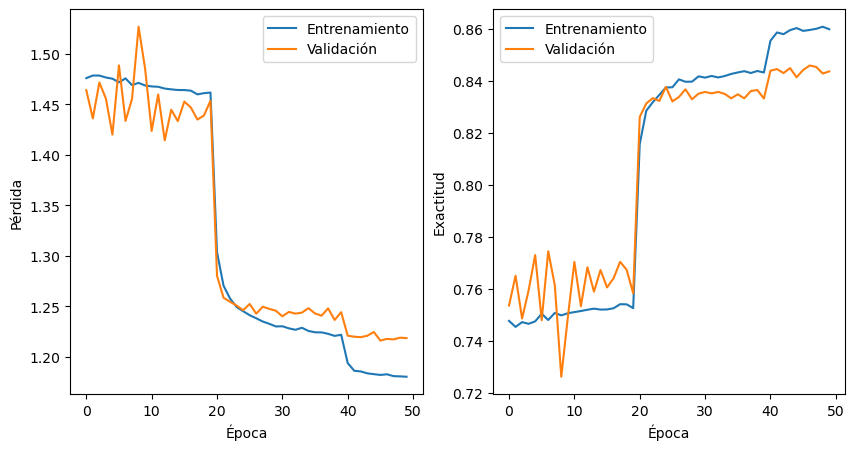

In [ ]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

## Prueba de la red en el conjunto de prueba

In [ ]:
model

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

In [ ]:
checkpoint = torch.load('/home/carmen/DL/logs/M5.pt')

epoca = checkpoint['epoch']
modelo_state_dict = checkpoint['model_state_dict']

model.load_state_dict(modelo_state_dict)

model.eval()


M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

In [ ]:
model.eval()
spectrogram = False

with th.no_grad():
    for Xlote,ylote in test_valida_loader:
    # Xlote = Xlote.float()  # Convierte la entrada a punto flotante (float)
        #print(X.to)
        #Xlote = Xlote.to(torch.float32)
        #Xlote = Xlote.to(torch.float)
        Xlote = Xlote.to(device)
        Xlote = transform(Xlote)
    # apply transform and model on whole batch directly on device
        if spectrogram:
            #modificamos para que las dimensiones conincidan con las del modelo
            #Xlote = Xlote.reshape(1, -1)
            #Se aplanan
            Xlote = torch.flatten(Xlote, start_dim=1)
            Xlote = Xlote.view(Xlote.shape[0], 1, Xlote.shape[1])

        ylote = ylote.type(torch.LongTensor)
        ylote = ylote.to(device)

        y_hat = model(Xlote)

        metrica = exactitud(y_hat.squeeze(), ylote)

metrica

tensor(0.7931, device='cuda:0')

Obtenemos 0.79 en el conjunto de prueba, el cual es muy bueno. Ahora veremos el desempeño con espectogramas.

## Usando transformaciones

### mel_spectrogram

In [ ]:
# Configurar los parámetros para los espectrogramas Mel
n_mels = 128
n_fft = 400
win_length = 400
hop_length = 160

# Crear una instancia de la transformación Spectrogram
mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels
)

# Calcular el espectrograma Mel
mel_spec = mel_spectrogram(waveform)


/home/carmen/anaconda3/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [ ]:
N_EPOCAS = 50
# The transform needs to live on the same device as the model and the data.
mel_spectrogram = mel_spectrogram.to(device)

M5, mejor_M5, hist = entrena(model,
                            perdida,
                            exactitud,
                            optimizer,
                            train_loader,
                            test_loader,
                            device,
                            save_path + '/M5_mel_spectrogram_1D.pt',
                            transform = mel_spectrogram,
                            n_epocas= N_EPOCAS,
                            tbdir = LOGDIR,
                            spectrogram=True)

  0%|          | 0/50 [00:00<?, ?it/s]


Época 0: Perdida(E) = 2.077, exactitud(E) = 0.528, Perdida(V) = 3.862, exactitud(V) = 0.128

Época 1: Perdida(E) = 2.064, exactitud(E) = 0.532, Perdida(V) = 3.775, exactitud(V) = 0.073

Época 2: Perdida(E) = 2.051, exactitud(E) = 0.540, Perdida(V) = 3.372, exactitud(V) = 0.158

Época 3: Perdida(E) = 2.043, exactitud(E) = 0.542, Perdida(V) = 4.019, exactitud(V) = 0.090

Época 4: Perdida(E) = 2.035, exactitud(E) = 0.543, Perdida(V) = 3.862, exactitud(V) = 0.084

Época 5: Perdida(E) = 2.029, exactitud(E) = 0.547, Perdida(V) = 4.137, exactitud(V) = 0.091

Época 6: Perdida(E) = 2.015, exactitud(E) = 0.551, Perdida(V) = 5.182, exactitud(V) = 0.063

Época 7: Perdida(E) = 2.019, exactitud(E) = 0.548, Perdida(V) = 3.520, exactitud(V) = 0.138

Época 8: Perdida(E) = 2.018, exactitud(E) = 0.550, Perdida(V) = 3.693, exactitud(V) = 0.145

Época 9: Perdida(E) = 1.842, exactitud(E) = 0.620, Perdida(V) = 3.435, exactitud(V) = 0.111

Época 10: Perdida(E) = 1.801, exactitud(E) = 0.636, Perdida(V) = 3.89

  0%|          | 0/50 [17:43<?, ?it/s]


Época 49: Perdida(E) = 1.645, exactitud(E) = 0.696, Perdida(V) = 3.735, exactitud(V) = 0.071


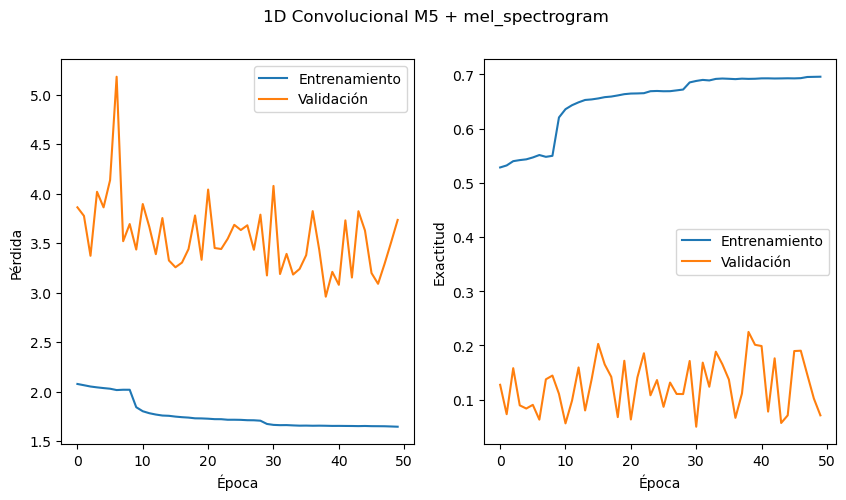

In [ ]:

graficar_entrenamiento("1D Convolucional M5 + mel_spectrogram", hist)


Se muestra un claro sobre ajuste, el conjunto de validación no mejora y no logra alcanzar el 0.3 de exactitud, mientras el de entrenamiento alcanza casi el 0.7.

### Espectrogramas Mel-Log:

In [ ]:
import torchaudio.transforms as T
import torch

# Define tus transformaciones individuales
transformations = [
    T.MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160, n_mels=128),
    T.AmplitudeToDB(),
]



/home/carmen/anaconda3/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
N_EPOCAS = 20
# The transform needs to live on the same device as the model and the data.
#transformations = transformations.to(device)

M5, mejor_M5, hist = entrena(model,
                            perdida,
                            exactitud,
                            optimizer,
                            train_loader,
                            test_loader,
                            device,
                            save_path + '/M5_mel_log_spectogram_1D.pt',
                            transform = transformations,
                            n_epocas= N_EPOCAS,
                            tbdir = LOGDIR,
                            spectrogram=True,
                            log_mel = True)

  0%|          | 0/20 [00:00<?, ?it/s]


Época 0: Perdida(E) = 4.040, exactitud(E) = 0.030, Perdida(V) = 4.058, exactitud(V) = 0.028

Época 1: Perdida(E) = 4.040, exactitud(E) = 0.030, Perdida(V) = 4.065, exactitud(V) = 0.027

Época 2: Perdida(E) = 4.040, exactitud(E) = 0.030, Perdida(V) = 4.056, exactitud(V) = 0.028

Época 3: Perdida(E) = 4.041, exactitud(E) = 0.030, Perdida(V) = 4.047, exactitud(V) = 0.027

Época 4: Perdida(E) = 4.040, exactitud(E) = 0.030, Perdida(V) = 4.066, exactitud(V) = 0.028

Época 5: Perdida(E) = 4.040, exactitud(E) = 0.030, Perdida(V) = 4.059, exactitud(V) = 0.027

Época 6: Perdida(E) = 4.041, exactitud(E) = 0.029, Perdida(V) = 4.048, exactitud(V) = 0.029

Época 7: Perdida(E) = 4.040, exactitud(E) = 0.030, Perdida(V) = 4.058, exactitud(V) = 0.028

Época 8: Perdida(E) = 4.041, exactitud(E) = 0.029, Perdida(V) = 4.041, exactitud(V) = 0.027

Época 9: Perdida(E) = 4.040, exactitud(E) = 0.030, Perdida(V) = 4.061, exactitud(V) = 0.028

Época 10: Perdida(E) = 4.039, exactitud(E) = 0.030, Perdida(V) = 4.06

  0%|          | 0/20 [07:06<?, ?it/s]


Época 19: Perdida(E) = 4.041, exactitud(E) = 0.030, Perdida(V) = 4.039, exactitud(V) = 0.027


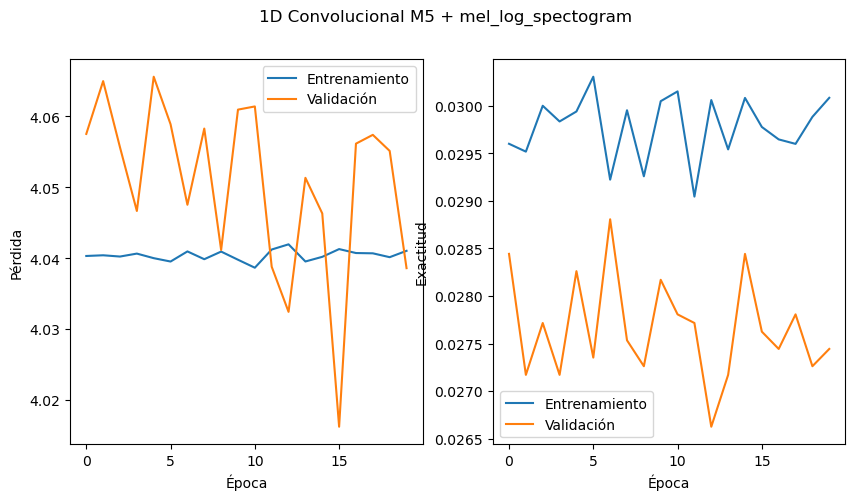

In [ ]:

graficar_entrenamiento("1D Convolucional M5 + mel_log_spectogram", hist)


Usando mel-log el desempeño es muy malo en comparación con los anteriores, no alcanza nisiquiera el 0.1 de exactitud. Una opción para mejorar sería utilizar datos mel-log, generados con diferentes parametros propios del espectograma.

### MFCCs (Mel-Frequency Cepstral Coefficients):

In [ ]:


N_EPOCAS = 100
# The transform needs to live on the same device as the model and the data.
mfcc = mfcc.to(device)

M5, mejor_M5, hist = entrena(model,
                            perdida,
                            exactitud,
                            optimizer,
                            train_loader,
                            test_loader,
                            device,
                            save_path + '/M5_mfcc_1D.pt',
                            transform = mfcc,
                            n_epocas= N_EPOCAS,
                            tbdir = LOGDIR,
                            spectrogram=True)

  0%|          | 0/100 [00:00<?, ?it/s]


Época 0: Perdida(E) = 2.075, exactitud(E) = 0.524, Perdida(V) = 2.048, exactitud(V) = 0.535

Época 1: Perdida(E) = 1.937, exactitud(E) = 0.578, Perdida(V) = 1.959, exactitud(V) = 0.569

Época 2: Perdida(E) = 1.878, exactitud(E) = 0.599, Perdida(V) = 1.937, exactitud(V) = 0.571

Época 3: Perdida(E) = 1.843, exactitud(E) = 0.614, Perdida(V) = 1.884, exactitud(V) = 0.596

Época 4: Perdida(E) = 1.820, exactitud(E) = 0.621, Perdida(V) = 2.069, exactitud(V) = 0.535

Época 5: Perdida(E) = 1.805, exactitud(E) = 0.627, Perdida(V) = 1.971, exactitud(V) = 0.571

Época 6: Perdida(E) = 1.797, exactitud(E) = 0.628, Perdida(V) = 1.896, exactitud(V) = 0.583

Época 7: Perdida(E) = 1.788, exactitud(E) = 0.631, Perdida(V) = 1.995, exactitud(V) = 0.553

Época 8: Perdida(E) = 1.782, exactitud(E) = 0.634, Perdida(V) = 1.839, exactitud(V) = 0.602

Época 9: Perdida(E) = 1.772, exactitud(E) = 0.638, Perdida(V) = 1.983, exactitud(V) = 0.560

Época 10: Perdida(E) = 1.763, exactitud(E) = 0.642, Perdida(V) = 1.93

  0%|          | 0/100 [36:35<?, ?it/s]


Época 99: Perdida(E) = 1.472, exactitud(E) = 0.752, Perdida(V) = 1.564, exactitud(V) = 0.708


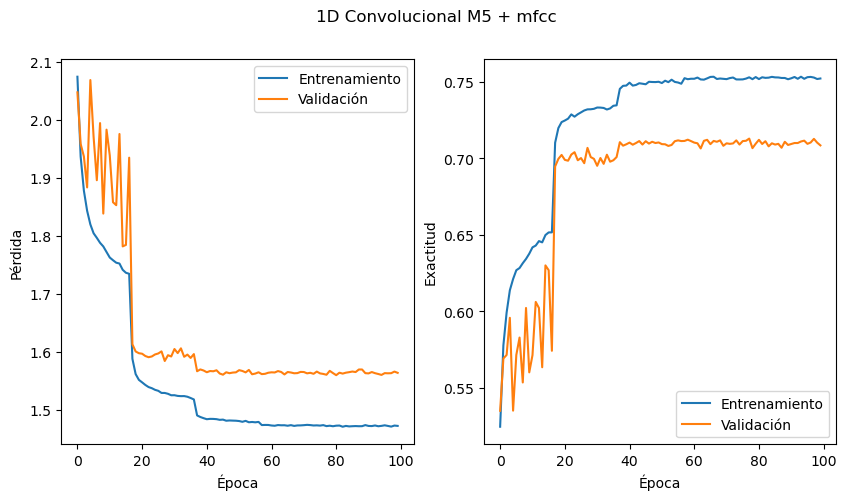

In [ ]:

graficar_entrenamiento("1D Convolucional M5 + mfcc", hist)


#### Prueba en el conjuto de prueba

Con este modelo haremos la prueba cn el conjunto de prueba ya que muestra un buen desempeño:

In [ ]:
model

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

In [ ]:

checkpoint = torch.load('/home/carmen/DL/logs/M5_mfcc_1D.pt')

epoca = checkpoint['epoch']
modelo_state_dict = checkpoint['model_state_dict']

model.load_state_dict(modelo_state_dict)

model.eval()


M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

In [ ]:
model.eval()
spectrogram = True
transform = mfcc
transform = transform.to(device)
with th.no_grad():
    for Xlote,ylote in test_valida_loader:
    # Xlote = Xlote.float()  # Convierte la entrada a punto flotante (float)
        #print(X.to)
        #Xlote = Xlote.to(torch.float32)
        #Xlote = Xlote.to(torch.float)
        Xlote = Xlote.to(device)
        Xlote = transform(Xlote)
    # apply transform and model on whole batch directly on device
        if spectrogram:
            #modificamos para que las dimensiones conincidan con las del modelo
            #Xlote = Xlote.reshape(1, -1)
            #Se aplanan
            Xlote = torch.flatten(Xlote, start_dim=1)
            Xlote = Xlote.view(Xlote.shape[0], 1, Xlote.shape[1])

        ylote = ylote.type(torch.LongTensor)
        ylote = ylote.to(device)

        y_hat = model(Xlote)

        metrica = exactitud(y_hat.squeeze(), ylote)

metrica

tensor(0.8621, device='cuda:0')

Utiliznado las transformacion mfcc el desemepeño mejora en comparación con la transformación simple, por otro lado vemos que las otras dos tranformaciones sobreajustan los datos o tienen métricas muy bajas.

# 3. Modelo basado en capas convolucionales 2D

La red CnnAudioNet es una red neuronal convolucional (CNN) diseñada para procesar datos de entrada en forma de imágenes, donde se espera que las imágenes tengan una sola banda o canal (escala de grises). La red se utiliza para la clasificación de datos y consta de varias capas de convolución, capas de max pooling, capas completamente conectadas y capas de normalización.

Para utilizar la red CnnAudioNet para tareas de procesamiento de audio, primero debemos convertir nuestros datos de audio en representaciones de imágenes que puedan ser procesadas por la red. Comúnmente, se utilizan representaciones de espectrogramas o melspectrogramas como entrada para redes CNN en tareas de procesamiento de audio.

## Arquitecturas

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CnnAudioNet(nn.Module):
    def __init__(self,NumClasses):
        super(CnnAudioNet,self).__init__()
        self.NumClasses = NumClasses
        self.Fc_features = 128
        self.C1 = nn.Conv2d(1, 32, 2)  # Cambiamos el tamaño del kernel a 2x2
        self.C2 = nn.Conv2d(32, 64, 2)  # Cambiamos el tamaño del kernel a 2x2
        self.C3 = nn.Conv2d(64, 128, 2)  # Cambiamos el tamaño del kernel a 2x2
        self.C4 = nn.Conv2d(128, 256, 2)  # Cambiamos el tamaño del kernel a 2x2
        self.BN1 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN4 = nn.BatchNorm2d(256)
        self.fc = nn.Linear(256, self.NumClasses)

    def forward(self, x):
        x = F.relu(self.BN1(self.C1(x)))
        x = F.relu(self.BN2(self.C2(x)))
        x = F.relu(self.BN3(self.C3(x)))
        x = F.relu(self.BN4(self.C4(x)))
        x = F.adaptive_avg_pool2d(x, (1, 1))  # Cambiamos a una capa de pooling global
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# obtenido en https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# modificada para que sean kernels de 2x2,
import torch.nn as nn
import torch.nn.functional as F

class CNN_2D(nn.Module):
    def __init__(self,NumClasses):
        super(CNN_2D,self).__init__()
        self.NumClasses = NumClasses
        self.Fc_features = 128
        self.C1 = nn.Conv2d(1, 32, 2)  # Cambiamos el tamaño del kernel a 2x2
        self.C2 = nn.Conv2d(32, 64, 2)  # Cambiamos el tamaño del kernel a 2x2
        self.C3 = nn.Conv2d(64, 128, 2)  # Cambiamos el tamaño del kernel a 2x2
        self.C4 = nn.Conv2d(128, 256, 2)  # Cambiamos el tamaño del kernel a 2x2
        self.BN1 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN4 = nn.BatchNorm2d(256)
        self.fc = nn.Linear(256, self.NumClasses)

    def forward(self, x):
        x = F.relu(self.BN1(self.C1(x)))
        x = F.relu(self.BN2(self.C2(x)))
        x = F.relu(self.BN3(self.C3(x)))
        x = F.relu(self.BN4(self.C4(x)))
        x = F.adaptive_avg_pool2d(x, (1, 1))  # Cambiamos a una capa de pooling global
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class ImprovedCNN_2D(nn.Module):
    def __init__(self, NumClasses):
        super(ImprovedCNN_2D, self).__init__()
        self.NumClasses = NumClasses
        self.Fc_features = 128
        self.C1 = nn.Conv2d(1, 32, 2)  # Kernel de 2x2
        self.C2 = nn.Conv2d(32, 64, 2)  # Kernel de 2x2
        self.C3 = nn.Conv2d(64, 128, 2)  # Kernel de 2x2
        self.C4 = nn.Conv2d(128, 256, 2)  # Kernel de 2x2
        self.BN1 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, self.NumClasses)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.BN1(self.C1(x)))
        x = F.relu(self.BN2(self.C2(x)))
        x = F.relu(self.BN3(self.C3(x)))
        x = F.relu(self.BN4(self.C4(x)))
        x = F.adaptive_avg_pool2d(x, (1, 1))  # Capa de pooling global
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
model = CNN_2D(len(labels))
model = model.to(device)  # Mueve el modelo a la GPU

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

Number of parameters: 182595


## Usando transformaciones

### Mel spectogram

In [ ]:
perdida = nn.CrossEntropyLoss(weight= None,
                              reduction='mean',
                              label_smoothing=0.1)

In [ ]:
N_EPOCAS = 5
# The transform needs to live on the same device as the model and the data.
mel_spectrogram = mel_spectrogram.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10


cnnAudioNet, mejor_cnnAudioNet, hist = entrena(model,
                                                perdida,
                                                exactitud,
                                                optimizer,
                                                train_loader,
                                                test_loader,
                                                device,
                                                save_path + '/CnnAudioNet_mel_spectrogram_2D.pt',
                                                transform = mel_spectrogram,
                                                n_epocas= N_EPOCAS,
                                                tbdir = LOGDIR,
                                                spectrogram = False)

  0%|          | 0/5 [00:00<?, ?it/s]


Época 0: Perdida(E) = 3.273, exactitud(E) = 0.118, Perdida(V) = 29.543, exactitud(V) = 0.038

Época 1: Perdida(E) = 3.004, exactitud(E) = 0.204, Perdida(V) = 26.216, exactitud(V) = 0.036

Época 2: Perdida(E) = 2.847, exactitud(E) = 0.257, Perdida(V) = 11.010, exactitud(V) = 0.051

Época 3: Perdida(E) = 2.779, exactitud(E) = 0.280, Perdida(V) = 23.926, exactitud(V) = 0.037


  0%|          | 0/5 [16:03<?, ?it/s]


Época 4: Perdida(E) = 2.738, exactitud(E) = 0.295, Perdida(V) = 688.834, exactitud(V) = 0.036


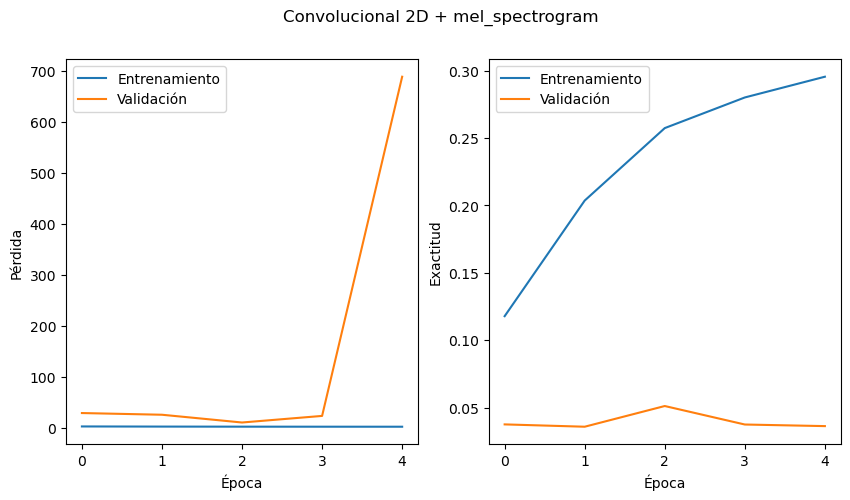

In [ ]:

graficar_entrenamiento("Convolucional 2D + mel_spectrogram", hist)


### MFCC

In [ ]:
N_EPOCAS = 20
mfcc = mfcc.to(device)
cnnAudioNet, mejor_cnnAudioNet, hist = entrena(model,
                                                perdida,
                                                exactitud,
                                                optimizer,
                                                train_loader,
                                                test_loader,
                                                device,
                                                save_path + '/CNN_2D_mfcc_2D.pt',
                                                transform = mfcc,
                                                n_epocas= N_EPOCAS,
                                                tbdir = LOGDIR,
                                                spectrogram = False)

  0%|          | 0/20 [00:00<?, ?it/s]


Época 0: Perdida(E) = 3.569, exactitud(E) = 0.020, Perdida(V) = 3.567, exactitud(V) = 0.020

Época 1: Perdida(E) = 3.569, exactitud(E) = 0.020, Perdida(V) = 3.567, exactitud(V) = 0.020

Época 2: Perdida(E) = 3.569, exactitud(E) = 0.020, Perdida(V) = 3.568, exactitud(V) = 0.020

Época 3: Perdida(E) = 3.569, exactitud(E) = 0.020, Perdida(V) = 3.567, exactitud(V) = 0.020

Época 4: Perdida(E) = 3.569, exactitud(E) = 0.020, Perdida(V) = 3.568, exactitud(V) = 0.019

Época 5: Perdida(E) = 3.569, exactitud(E) = 0.020, Perdida(V) = 3.567, exactitud(V) = 0.020

Época 6: Perdida(E) = 3.569, exactitud(E) = 0.020, Perdida(V) = 3.567, exactitud(V) = 0.020

Época 7: Perdida(E) = 3.569, exactitud(E) = 0.020, Perdida(V) = 3.568, exactitud(V) = 0.020

Época 8: Perdida(E) = 3.569, exactitud(E) = 0.020, Perdida(V) = 3.567, exactitud(V) = 0.020

Época 9: Perdida(E) = 3.569, exactitud(E) = 0.020, Perdida(V) = 3.567, exactitud(V) = 0.020

Época 10: Perdida(E) = 3.569, exactitud(E) = 0.020, Perdida(V) = 3.56

  0%|          | 0/20 [48:21<?, ?it/s]


Época 19: Perdida(E) = 3.569, exactitud(E) = 0.020, Perdida(V) = 3.568, exactitud(V) = 0.019


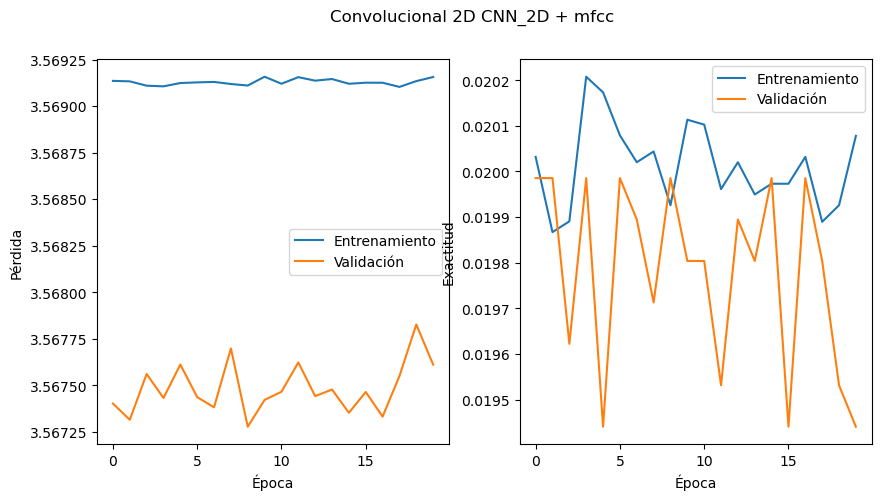

In [ ]:

graficar_entrenamiento("Convolucional 2D CNN_2D + mfcc", hist)


In [ ]:
model = ImprovedCNN_2D(len(labels))
model = model.to(device)  # Mueve el modelo a la GPU

N_EPOCAS = 5
# The transform needs to live on the same device as the model and the data.
mel_spectrogram = mel_spectrogram.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10


cnnAudioNet, mejor_cnnAudioNet, hist = entrena(model,
                                                perdida,
                                                exactitud,
                                                optimizer,
                                                train_loader,
                                                test_loader,
                                                device,
                                                save_path + '/ImprovedAudioNet_mel_spectrogram_2D.pt',
                                                transform = mel_spectrogram,
                                                n_epocas= N_EPOCAS,
                                                tbdir = LOGDIR,
                                                spectrogram = False)

  0%|          | 0/5 [00:00<?, ?it/s]


Época 0: Perdida(E) = 3.372, exactitud(E) = 0.082, Perdida(V) = 92.623, exactitud(V) = 0.015

Época 1: Perdida(E) = 3.266, exactitud(E) = 0.108, Perdida(V) = 3.380, exactitud(V) = 0.100

Época 2: Perdida(E) = 3.237, exactitud(E) = 0.119, Perdida(V) = 3.114, exactitud(V) = 0.150

Época 3: Perdida(E) = 3.205, exactitud(E) = 0.127, Perdida(V) = 3.395, exactitud(V) = 0.077


  0%|          | 0/5 [15:01<?, ?it/s]


Época 4: Perdida(E) = 3.182, exactitud(E) = 0.131, Perdida(V) = 41.708, exactitud(V) = 0.019


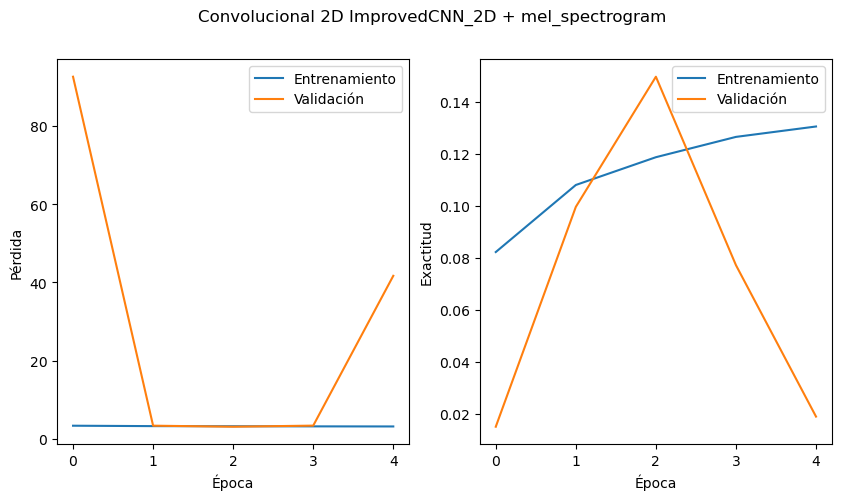

In [ ]:

graficar_entrenamiento("Convolucional 2D ImprovedCNN_2D + mel_spectrogram", hist)


In [ ]:

N_EPOCAS = 100
# The transform needs to live on the same device as the model and the data.
mel_spectrogram = mel_spectrogram.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10


cnnAudioNet, mejor_cnnAudioNet, hist = entrena(model,
                                                perdida,
                                                exactitud,
                                                optimizer,
                                                train_loader,
                                                test_loader,
                                                device,
                                                save_path + '/ImprovedAudioNet_mfcc_2D.pt',
                                                transform = mfcc,
                                                n_epocas= N_EPOCAS,
                                                tbdir = LOGDIR,
                                                spectrogram = False)

  0%|          | 0/100 [00:00<?, ?it/s]


Época 0: Perdida(E) = 2.290, exactitud(E) = 0.441, Perdida(V) = 1.884, exactitud(V) = 0.595

Época 1: Perdida(E) = 2.257, exactitud(E) = 0.457, Perdida(V) = 1.844, exactitud(V) = 0.617

Época 2: Perdida(E) = 2.241, exactitud(E) = 0.464, Perdida(V) = 1.897, exactitud(V) = 0.612

Época 3: Perdida(E) = 2.224, exactitud(E) = 0.470, Perdida(V) = 1.998, exactitud(V) = 0.570

Época 4: Perdida(E) = 2.213, exactitud(E) = 0.474, Perdida(V) = 1.789, exactitud(V) = 0.647

Época 5: Perdida(E) = 2.205, exactitud(E) = 0.479, Perdida(V) = 1.806, exactitud(V) = 0.654

Época 6: Perdida(E) = 2.200, exactitud(E) = 0.480, Perdida(V) = 1.763, exactitud(V) = 0.671

Época 7: Perdida(E) = 2.178, exactitud(E) = 0.488, Perdida(V) = 1.777, exactitud(V) = 0.646

Época 8: Perdida(E) = 2.177, exactitud(E) = 0.491, Perdida(V) = 1.792, exactitud(V) = 0.649

Época 9: Perdida(E) = 2.171, exactitud(E) = 0.492, Perdida(V) = 1.740, exactitud(V) = 0.657

Época 10: Perdida(E) = 2.167, exactitud(E) = 0.491, Perdida(V) = 1.77

  0%|          | 0/100 [4:00:43<?, ?it/s]


Época 99: Perdida(E) = 1.546, exactitud(E) = 0.752, Perdida(V) = 1.344, exactitud(V) = 0.812


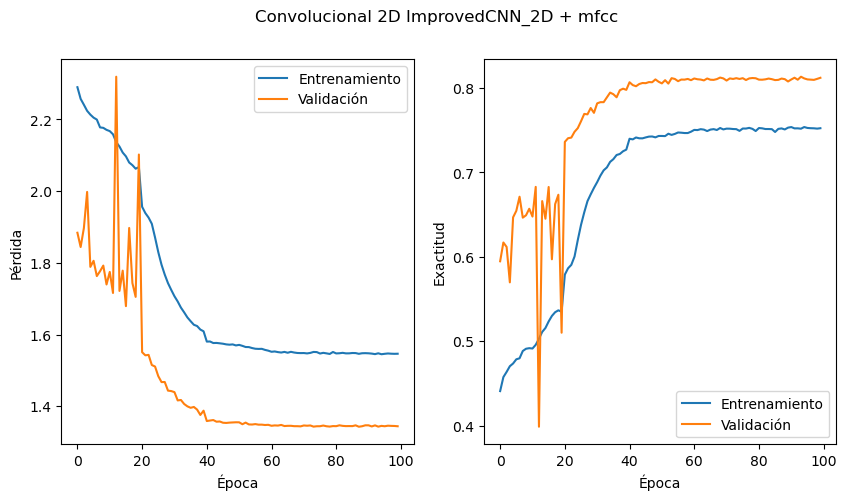

In [ ]:

graficar_entrenamiento("Convolucional 2D ImprovedCNN_2D + mfcc", hist)


Haremos la predicción sobre este modelo en el conjunto de prueba pues alcanzó un buen despeño:

In [ ]:
model

ImprovedCNN_2D(
  (C1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (C2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (C3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (C4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=35, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
model.eval()
spectrogram = False

with th.no_grad():
    for Xlote,ylote in test_valida_loader:
    # Xlote = Xlote.float()  # Convierte la entrada a punto flotante (float)
        #print(X.to)
        #Xlote = Xlote.to(torch.float32)
        #Xlote = Xlote.to(torch.float)
        Xlote = Xlote.to(device)
        Xlote = mfcc(Xlote)
    # apply transform and model on whole batch directly on device
        if spectrogram:
            #modificamos para que las dimensiones conincidan con las del modelo
            #Xlote = Xlote.reshape(1, -1)
            #Se aplanan
            Xlote = torch.flatten(Xlote, start_dim=1)
            Xlote = Xlote.view(Xlote.shape[0], 1, Xlote.shape[1])

        ylote = ylote.type(torch.LongTensor)
        ylote = ylote.to(device)

        y_hat = model(Xlote)

        metrica = exactitud(y_hat.squeeze(), ylote)

metrica

tensor(0.8966, device='cuda:0')

Obtenemos un 0.866 en el conjunto de prueba, lo que indica que fue un buen modelo, además de que como hemos visto en las arquitecturas anteriores, el utilizar mfcc como entrada representa mejor las caracteristicas de los audios, generando modelos con mayor exactitud.

Ahora cambiaremos un poco la red y probemos de nuevo, ademśa probaremos con tasas más pequeñas-

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN_2D(nn.Module):
    def __init__(self, NumClasses):
        super(ImprovedCNN_2D, self).__init__()
        self.NumClasses = NumClasses
        self.C1 = nn.Conv2d(1, 32, 3, padding=1)
        self.C2 = nn.Conv2d(32, 64, 3, padding=1)
        self.C3 = nn.Conv2d(64, 128, 3, padding=1)
        self.C4 = nn.Conv2d(128, 256, 3, padding=1)
        self.BN1 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, self.NumClasses)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.BN1(self.C1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.BN2(self.C2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.BN3(self.C3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.BN4(self.C4(x)))
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
model = ImprovedCNN_2D(len(labels))
model = model.to(device)  # Mueve el modelo a la GPU

N_EPOCAS = 20
# The transform needs to live on the same device as the model and the data.
mel_spectrogram = mel_spectrogram.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10


cnnAudioNet, mejor_cnnAudioNet, hist = entrena(model,
                                                perdida,
                                                exactitud,
                                                optimizer,
                                                train_loader,
                                                test_loader,
                                                device,
                                                save_path + '/ImprovedAudioNet_mel_spectrogram_2D.pt',
                                                transform = mel_spectrogram,
                                                n_epocas= N_EPOCAS,
                                                tbdir = LOGDIR,
                                                spectrogram = False)

  0%|          | 0/20 [00:00<?, ?it/s]


Época 0: Perdida(E) = 3.094, exactitud(E) = 0.155, Perdida(V) = 5.033, exactitud(V) = 0.046

Época 1: Perdida(E) = 2.476, exactitud(E) = 0.370, Perdida(V) = 16.301, exactitud(V) = 0.052

Época 2: Perdida(E) = 2.078, exactitud(E) = 0.532, Perdida(V) = 3.768, exactitud(V) = 0.049

Época 3: Perdida(E) = 1.891, exactitud(E) = 0.611, Perdida(V) = 3.793, exactitud(V) = 0.072

Época 4: Perdida(E) = 1.771, exactitud(E) = 0.664, Perdida(V) = 2.969, exactitud(V) = 0.249

Época 5: Perdida(E) = 1.684, exactitud(E) = 0.699, Perdida(V) = 2.393, exactitud(V) = 0.482

Época 6: Perdida(E) = 1.616, exactitud(E) = 0.729, Perdida(V) = 4.818, exactitud(V) = 0.122

Época 7: Perdida(E) = 1.561, exactitud(E) = 0.750, Perdida(V) = 2.344, exactitud(V) = 0.434

Época 8: Perdida(E) = 1.517, exactitud(E) = 0.768, Perdida(V) = 2.736, exactitud(V) = 0.314

Época 9: Perdida(E) = 1.477, exactitud(E) = 0.783, Perdida(V) = 2.575, exactitud(V) = 0.350

Época 10: Perdida(E) = 1.362, exactitud(E) = 0.830, Perdida(V) = 3.8

  0%|          | 0/20 [11:15<?, ?it/s]


Época 19: Perdida(E) = 1.227, exactitud(E) = 0.881, Perdida(V) = 2.587, exactitud(V) = 0.405


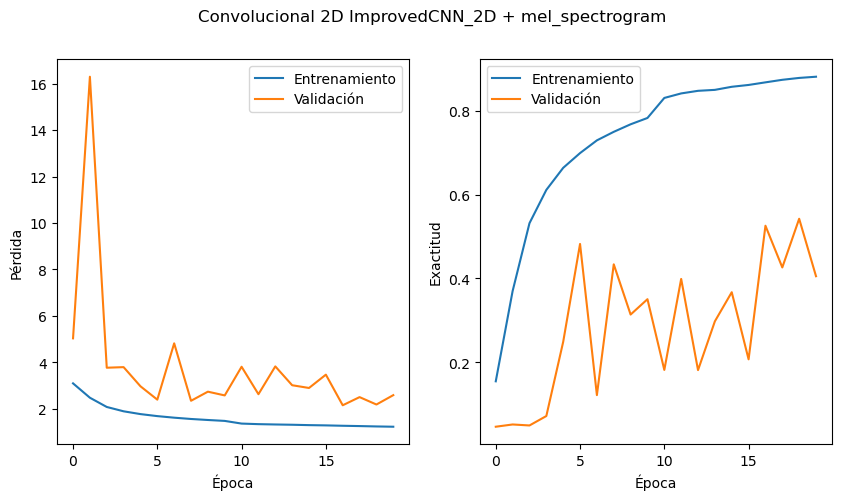

In [ ]:
graficar_entrenamiento("Convolucional 2D ImprovedCNN_2D + mel_spectrogram", hist)

In [ ]:
#model = CnnAudioNet(len(labels))
model = model.to(device)  # Mueve el modelo a la GPU

N_EPOCAS = 50
# The transform needs to live on the same device as the model and the data.
mel_spectrogram = mel_spectrogram.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10


cnnAudioNet, mejor_cnnAudioNet, hist = entrena(model,
                                                perdida,
                                                exactitud,
                                                optimizer,
                                                train_loader,
                                                test_loader,
                                                device,
                                                save_path + '/ImprovedAudioNet_mfcc_2D.pt',
                                                transform = mfcc,
                                                n_epocas= N_EPOCAS,
                                                tbdir = LOGDIR,
                                                spectrogram = False)

  0%|          | 0/50 [00:00<?, ?it/s]


Época 0: Perdida(E) = 1.772, exactitud(E) = 0.658, Perdida(V) = 1.265, exactitud(V) = 0.832

Época 1: Perdida(E) = 1.332, exactitud(E) = 0.829, Perdida(V) = 1.127, exactitud(V) = 0.880

Época 2: Perdida(E) = 1.212, exactitud(E) = 0.873, Perdida(V) = 1.030, exactitud(V) = 0.912

Época 3: Perdida(E) = 1.146, exactitud(E) = 0.893, Perdida(V) = 1.003, exactitud(V) = 0.915

Época 4: Perdida(E) = 1.102, exactitud(E) = 0.905, Perdida(V) = 1.008, exactitud(V) = 0.911

Época 5: Perdida(E) = 1.071, exactitud(E) = 0.914, Perdida(V) = 0.971, exactitud(V) = 0.924

Época 6: Perdida(E) = 1.049, exactitud(E) = 0.920, Perdida(V) = 0.947, exactitud(V) = 0.931

Época 7: Perdida(E) = 1.028, exactitud(E) = 0.926, Perdida(V) = 0.933, exactitud(V) = 0.934

Época 8: Perdida(E) = 1.015, exactitud(E) = 0.929, Perdida(V) = 0.935, exactitud(V) = 0.931

Época 9: Perdida(E) = 1.001, exactitud(E) = 0.931, Perdida(V) = 0.934, exactitud(V) = 0.930

Época 10: Perdida(E) = 0.991, exactitud(E) = 0.933, Perdida(V) = 0.92

  0%|          | 0/50 [23:10<?, ?it/s]


KeyboardInterrupt: 

Detendremos el entrenamiento pues el desempeño se ve bastante bien en los conjuntos tanto como entrenamiento como de validación.

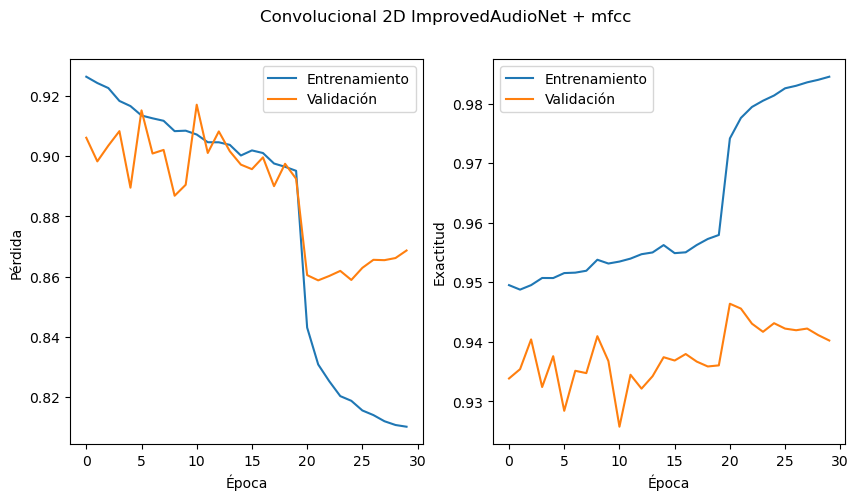

In [ ]:
graficar_entrenamiento("Convolucional 2D ImprovedAudioNet + mfcc", hist)

In [ ]:
#model = CnnAudioNet(len(labels))
model = model.to(device)  # Mueve el modelo a la GPU

N_EPOCAS = 30
# The transform needs to live on the same device as the model and the data.
mel_spectrogram = mel_spectrogram.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10


cnnAudioNet, mejor_cnnAudioNet, hist = entrena(model,
                                                perdida,
                                                exactitud,
                                                optimizer,
                                                train_loader,
                                                test_loader,
                                                device,
                                                save_path + '/ImprovedAudioNet_mfcc_2D.pt',
                                                transform = mfcc,
                                                n_epocas= N_EPOCAS,
                                                tbdir = LOGDIR,
                                                spectrogram = False)

  0%|          | 0/30 [00:00<?, ?it/s]


Época 0: Perdida(E) = 0.926, exactitud(E) = 0.950, Perdida(V) = 0.906, exactitud(V) = 0.934

Época 1: Perdida(E) = 0.924, exactitud(E) = 0.949, Perdida(V) = 0.898, exactitud(V) = 0.935

Época 2: Perdida(E) = 0.923, exactitud(E) = 0.950, Perdida(V) = 0.903, exactitud(V) = 0.940

Época 3: Perdida(E) = 0.918, exactitud(E) = 0.951, Perdida(V) = 0.908, exactitud(V) = 0.932

Época 4: Perdida(E) = 0.917, exactitud(E) = 0.951, Perdida(V) = 0.890, exactitud(V) = 0.938

Época 5: Perdida(E) = 0.913, exactitud(E) = 0.952, Perdida(V) = 0.915, exactitud(V) = 0.928

Época 6: Perdida(E) = 0.913, exactitud(E) = 0.952, Perdida(V) = 0.901, exactitud(V) = 0.935

Época 7: Perdida(E) = 0.912, exactitud(E) = 0.952, Perdida(V) = 0.902, exactitud(V) = 0.935

Época 8: Perdida(E) = 0.908, exactitud(E) = 0.954, Perdida(V) = 0.887, exactitud(V) = 0.941

Época 9: Perdida(E) = 0.908, exactitud(E) = 0.953, Perdida(V) = 0.890, exactitud(V) = 0.937

Época 10: Perdida(E) = 0.907, exactitud(E) = 0.953, Perdida(V) = 0.91

  0%|          | 0/30 [20:46<?, ?it/s]


Época 29: Perdida(E) = 0.810, exactitud(E) = 0.985, Perdida(V) = 0.869, exactitud(V) = 0.940


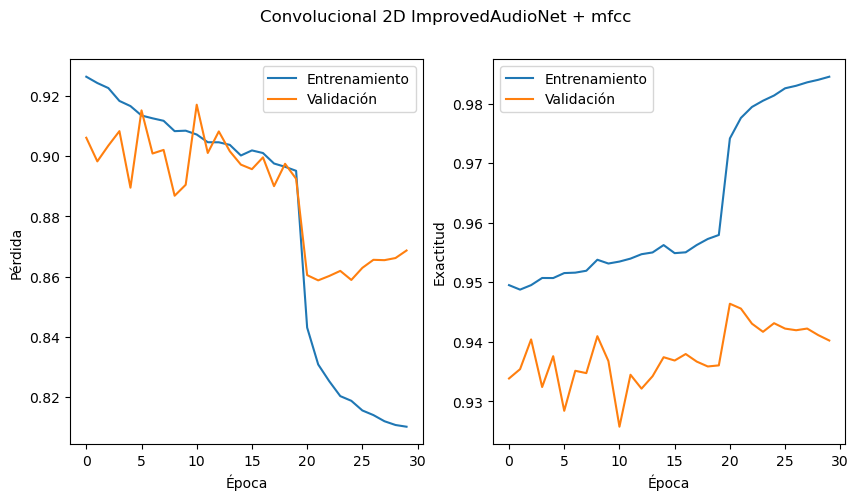

In [ ]:
graficar_entrenamiento("Convolucional 2D ImprovedAudioNet + mfcc", hist)

In [ ]:
model

ImprovedCNN_2D(
  (C1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=35, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
model.eval()
spectrogram = False

with th.no_grad():
    for Xlote,ylote in test_valida_loader:
    # Xlote = Xlote.float()  # Convierte la entrada a punto flotante (float)
        #print(X.to)
        #Xlote = Xlote.to(torch.float32)
        #Xlote = Xlote.to(torch.float)
        Xlote = Xlote.to(device)
        Xlote = mfcc(Xlote)
    # apply transform and model on whole batch directly on device
        if spectrogram:
            #modificamos para que las dimensiones conincidan con las del modelo
            #Xlote = Xlote.reshape(1, -1)
            #Se aplanan
            Xlote = torch.flatten(Xlote, start_dim=1)
            Xlote = Xlote.view(Xlote.shape[0], 1, Xlote.shape[1])

        ylote = ylote.type(torch.LongTensor)
        ylote = ylote.to(device)

        y_hat = model(Xlote)

        metrica = exactitud(y_hat.squeeze(), ylote)

metrica

tensor(0.9310, device='cuda:0')

In [ ]:
#model = CnnAudioNet(len(labels))
model = model.to(device)  # Mueve el modelo a la GPU

N_EPOCAS = 15
# The transform needs to live on the same device as the model and the data.
mel_spectrogram = mel_spectrogram.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10


cnnAudioNet, mejor_cnnAudioNet, hist = entrena(model,
                                                perdida,
                                                exactitud,
                                                optimizer,
                                                train_loader,
                                                test_loader,
                                                device,
                                                save_path + '/ImprovedAudioNet_mfcc_2D_3.pt',
                                                transform = mfcc,
                                                n_epocas= N_EPOCAS,
                                                tbdir = LOGDIR,
                                                spectrogram = False)

  0%|          | 0/15 [00:00<?, ?it/s]


Época 0: Perdida(E) = 0.893, exactitud(E) = 0.958, Perdida(V) = 0.898, exactitud(V) = 0.936

Época 1: Perdida(E) = 0.895, exactitud(E) = 0.957, Perdida(V) = 0.904, exactitud(V) = 0.931

Época 2: Perdida(E) = 0.892, exactitud(E) = 0.958, Perdida(V) = 0.893, exactitud(V) = 0.936

Época 3: Perdida(E) = 0.892, exactitud(E) = 0.958, Perdida(V) = 0.896, exactitud(V) = 0.935

Época 4: Perdida(E) = 0.892, exactitud(E) = 0.958, Perdida(V) = 0.908, exactitud(V) = 0.931

Época 5: Perdida(E) = 0.892, exactitud(E) = 0.958, Perdida(V) = 0.902, exactitud(V) = 0.935

Época 6: Perdida(E) = 0.890, exactitud(E) = 0.959, Perdida(V) = 0.899, exactitud(V) = 0.933

Época 7: Perdida(E) = 0.889, exactitud(E) = 0.959, Perdida(V) = 0.892, exactitud(V) = 0.936

Época 8: Perdida(E) = 0.890, exactitud(E) = 0.959, Perdida(V) = 0.901, exactitud(V) = 0.932

Época 9: Perdida(E) = 0.888, exactitud(E) = 0.959, Perdida(V) = 0.904, exactitud(V) = 0.932

Época 10: Perdida(E) = 0.886, exactitud(E) = 0.959, Perdida(V) = 0.89

  0%|          | 0/15 [10:23<?, ?it/s]


Época 14: Perdida(E) = 0.884, exactitud(E) = 0.961, Perdida(V) = 0.886, exactitud(V) = 0.940


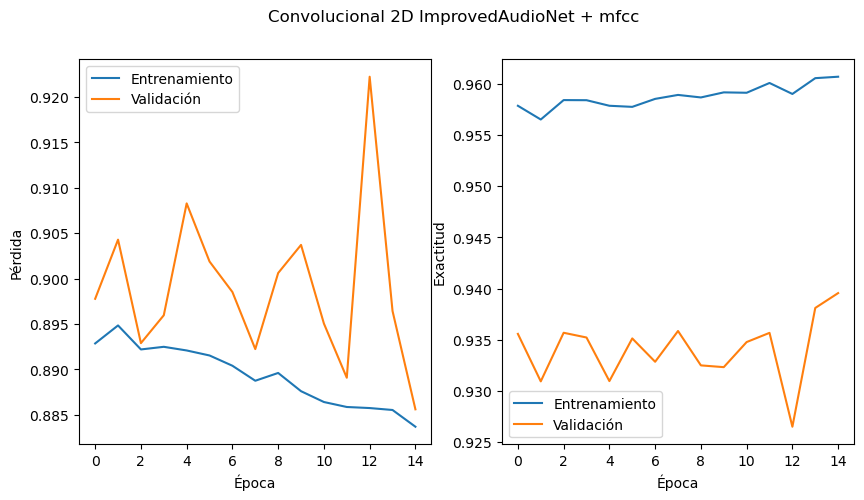

In [ ]:
graficar_entrenamiento("Convolucional 2D ImprovedAudioNet + mfcc", hist)

In [ ]:
model.eval()
spectrogram = False

met = []

with th.no_grad():
    for Xlote,ylote in test_valida_loader:
    # Xlote = Xlote.float()  # Convierte la entrada a punto flotante (float)
        #print(X.to)
        #Xlote = Xlote.to(torch.float32)
        #Xlote = Xlote.to(torch.float)
        Xlote = Xlote.to(device)
        Xlote = mfcc(Xlote)
    # apply transform and model on whole batch directly on device
        if spectrogram:
            #modificamos para que las dimensiones conincidan con las del modelo
            #Xlote = Xlote.reshape(1, -1)
            #Se aplanan
            Xlote = torch.flatten(Xlote, start_dim=1)
            Xlote = Xlote.view(Xlote.shape[0], 1, Xlote.shape[1])

        ylote = ylote.type(torch.LongTensor)
        ylote = ylote.to(device)

        y_hat = model(Xlote)
        met.append(exactitud(y_hat.squeeze(), ylote))


metrica

tensor(0.9310, device='cuda:0')

In [ ]:
met_cpu = [tensor.to('cpu') for tensor in met]  # Mueve los tensores a la CPU
met_numpy = [tensor.numpy() for tensor in met_cpu]  # Convierte los tensores a arreglos NumPy

# Calcula la media
media = np.mean(met_numpy)
media

0.9469151

In [ ]:
model2 = ImprovedCNN_2D(len(labels))
model2 = model.to(device)  # Mueve el modelo a la GPU

N_EPOCAS = 15
# The transform needs to live on the same device as the model and the data.
mel_spectrogram = mel_spectrogram.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10


cnnAudioNet, mejor_cnnAudioNet, hist = entrena(model2,
                                                perdida,
                                                exactitud,
                                                optimizer,
                                                train_loader,
                                                test_loader,
                                                device,
                                                save_path + '/ImprovedAudioNet_mfcc_2D_4.pt',
                                                transform = mfcc,
                                                n_epocas= N_EPOCAS,
                                                tbdir = LOGDIR,
                                                spectrogram = False)


  0%|          | 0/15 [00:00<?, ?it/s]


Época 0: Perdida(E) = 0.887, exactitud(E) = 0.959, Perdida(V) = 0.907, exactitud(V) = 0.932

Época 1: Perdida(E) = 0.885, exactitud(E) = 0.960, Perdida(V) = 0.903, exactitud(V) = 0.933

Época 2: Perdida(E) = 0.883, exactitud(E) = 0.961, Perdida(V) = 0.896, exactitud(V) = 0.934

Época 3: Perdida(E) = 0.883, exactitud(E) = 0.961, Perdida(V) = 0.893, exactitud(V) = 0.938

Época 4: Perdida(E) = 0.882, exactitud(E) = 0.961, Perdida(V) = 0.905, exactitud(V) = 0.930

Época 5: Perdida(E) = 0.880, exactitud(E) = 0.962, Perdida(V) = 0.917, exactitud(V) = 0.924

Época 6: Perdida(E) = 0.880, exactitud(E) = 0.962, Perdida(V) = 0.899, exactitud(V) = 0.933

Época 7: Perdida(E) = 0.880, exactitud(E) = 0.962, Perdida(V) = 0.898, exactitud(V) = 0.933

Época 8: Perdida(E) = 0.879, exactitud(E) = 0.962, Perdida(V) = 0.891, exactitud(V) = 0.937

Época 9: Perdida(E) = 0.881, exactitud(E) = 0.961, Perdida(V) = 0.897, exactitud(V) = 0.935

Época 10: Perdida(E) = 0.878, exactitud(E) = 0.962, Perdida(V) = 0.89

  0%|          | 0/15 [10:15<?, ?it/s]


Época 14: Perdida(E) = 0.878, exactitud(E) = 0.963, Perdida(V) = 0.906, exactitud(V) = 0.933


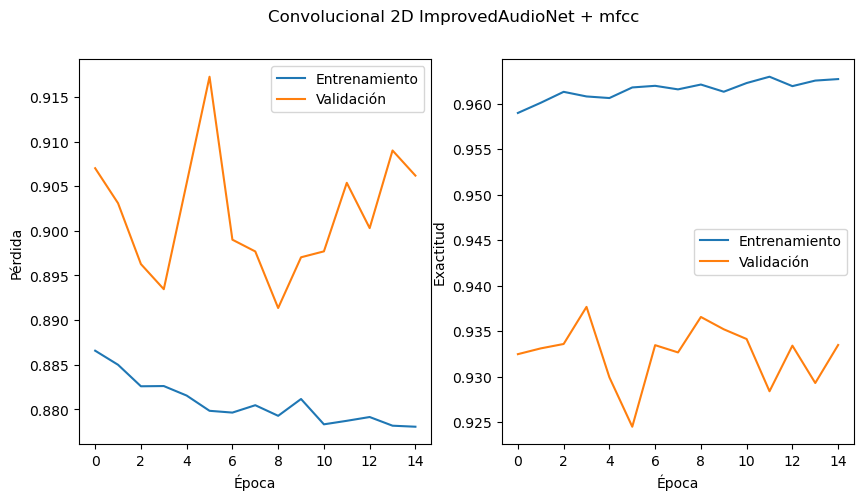

In [ ]:
graficar_entrenamiento("Convolucional 2D ImprovedAudioNet + mfcc", hist)

Evaluación con el conjunto de prueba:

In [ ]:
model2.eval()
spectrogram = False

met = []

with th.no_grad():
    for Xlote,ylote in test_valida_loader:
    # Xlote = Xlote.float()  # Convierte la entrada a punto flotante (float)
        #print(X.to)
        #Xlote = Xlote.to(torch.float32)
        #Xlote = Xlote.to(torch.float)
        Xlote = Xlote.to(device)
        Xlote = mfcc(Xlote)
    # apply transform and model on whole batch directly on device
        if spectrogram:
            #modificamos para que las dimensiones conincidan con las del modelo
            #Xlote = Xlote.reshape(1, -1)
            #Se aplanan
            Xlote = torch.flatten(Xlote, start_dim=1)
            Xlote = Xlote.view(Xlote.shape[0], 1, Xlote.shape[1])

        ylote = ylote.type(torch.LongTensor)
        ylote = ylote.to(device)

        y_hat = model2(Xlote)
        met.append(exactitud(y_hat.squeeze(), ylote))


met_cpu = [tensor.to('cpu') for tensor in met]  # Mueve los tensores a la CPU
met_numpy = [tensor.numpy() for tensor in met_cpu]  # Convierte los tensores a arreglos NumPy

# Calcula la media
media = np.mean(met_numpy)
media

0.9421868

In [ ]:
model2

ImprovedCNN_2D(
  (C1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=35, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

El mejor modelo lo obtuvimos usando la segunda arquitectura de la ImprovedCNN_2D, obteniendo un 0.94 de exactitud en el conjunto de prueba. También observamos que el uso de MFCCs mejora el desempeño en comparación con los otros espectogramas probados con las mismas arquitectura. Además de eso, podemos observar que con muy pocas epocas ya se alcanzan buenos resultados. No exploramos más configuraciones de la arquictura CNNAudionet ya que con nuestra segunda ImprovedCNN_2D obtuvimos excelentes resultados con pocas épocas.